# Lesson 6 - Persistent homology

> A first look at persistent homology, the workhorse underlying topological machine learning.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson06_persistent-homology.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson06_persistent-homology.ipynb)

## Learning objectives

* Understand the basic concepts behind persistent homology, especially how to interpret peristent diagrams
* Understand how to convert persistent diagrams into machine learning features
* Gain an introduction into the application of persistent homology to images

## References

* [_Persistent Homology: A Non-Mathy Introduction with Examples_](https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0) by G. Koplik
* Chapter 2 of [_An Introduction to Topological Data Analysis for Physicists: From LGM to FRBs_](https://arxiv.org/abs/1904.11044) by J. Murugan and D. Robertson
* [_Getting Started with giotto-tda_](https://towardsdatascience.com/getting-started-with-giotto-learn-a-python-library-for-topological-machine-learning-451d88d2c4bc) by L. Tunstall et al
* [_A Topological “Reading” Lesson: Classification of MNIST using TDA_](https://arxiv.org/pdf/1910.08345.pdf) by A. Garin and G. Tauzin

## What is persistent homology?

<div style="text-align: center">
<img src='images/persistence.gif'>
</div>

In general terms, persistent homology focuses on answering the question

> As one increases a threshold, at what scale do we observe changes in some geometric representation of the data?

The answer to this question involves [deep mathematics](https://arxiv.org/abs/1710.04019) and will not be covered 
here. Instead we wil focus on introducing the main concepts that are needed to extract topologial features from data, and how these features can be combined with machine learning algorithms.

<div style="text-align: center">
<img src='images/jackie.jpg' width='400'>
</div>

It turns out that persistent homology is well suited for detecting structure in high dimensional datasets, so it is no surprise that the technique has mostly been applied in cosmology to either [constrain non-Gaussianity in the CMB](https://arxiv.org/pdf/1712.08159.pdf) or find [cosmic voids or filament loops](https://arxiv.org/pdf/1811.08450.pdf) in the large-scale structure of matter. Persistent homology does not appear to have been used in particle physics, so perhaps the time is ripe for the enterprising graduate student 🤓!

## Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from typing import List
from PIL import Image
from hepml.core import download_dataset
from scipy import ndimage

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from hepml.core import make_point_clouds, load_shapes

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# dataviz
import matplotlib.pyplot as plt

## Download data

In [ ]:
DATA = Path('../data/')

In [ ]:
download_dataset("shapes.zip")
download_dataset("Cells.jpg")
download_dataset("BlackHole.jpg")

Dataset already exists at '../data/shapes.zip' and is not downloaded again.
Dataset already exists at '../data/Cells.jpg' and is not downloaded again.
Dataset already exists at '../data/BlackHole.jpg' and is not downloaded again.


In [ ]:
# uncomment to unzip the shapes folder
# !unzip {DATA}/'shapes.zip' -d {DATA}

## 3D shape classification

<div style="text-align: center">
<img src='images/semantic-ptcl.gif' width='800'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://pythonawesome.com/semantic-and-instance-segmentation-of-lidar-point-clouds-for-autonomous-driving/ </p>
</div>

Techniques for analyzing 3D shapes are becoming increasingly important due to the vast number of sensors such as LiDAR that are capturing 3D data, as well as numerous computer graphics applications.  These raw data are typically collected in the form of a _point cloud_, which corresponds to a set of 3D points $\{p_i | i = 1, \ldots, n\}$, where each point $p_i$ is a vector of its $(x, y, z)$ coordinates plus extra
feature channels such as color, intensity etc. Typically Euclidean distance is used to calculate the distances between any two points.

By finding suitable representations of these point clouds, machine learning can be used to solve a variety of tasks such as those shown in the figure below.

<div style="text-align: center">
<img src='images/3d-tasks.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> adapted from https://arxiv.org/abs/1612.00593 </p>
</div>

In this section we will examine how topological features can be extracted from point cloud data and fed to a simple classifier to distinguish 3D shapes.

### Generate simple shapes

To get started, let's generate a synthetic dataset of noisy circles, spheres, and tori, where the effect of noise is to displace the points that sample the surfaces by a random amount in a random direction:

In [ ]:
point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=20, noise=0.5)
point_clouds_basic.shape, labels_basic.shape

Here the labels are defined to that a circle is 0, a sphere is 1, and a torus is 2. Each point cloud corresponds to a sampling of the continuous surface - in this case 400 points are sampled per shape. As a sanity check, let's visualise these points clouds:

In [ ]:
# expect circle
plot_point_cloud(point_clouds_basic[0])

In [ ]:
# expect sphere
plot_point_cloud(point_clouds_basic[10])

In [ ]:
# expect torus
plot_point_cloud(point_clouds_basic[-1])

### From data to persistence diagrams
In raw form, point cloud data is not well suited for most machine learning algorithms because we ultimately need a _feature matrix_ $X$ where each row corresponds to a single sample (i.e. point cloud) and each column corresponds to a particular feature. In our example, each point cloud corresponds to a _collection_ of 3-dimensional vectors, so we need some way of representing this information in terms of a _single_ vector $x^{(i)}$ of feature values.

In this lesson we will use persistent homology to generate a topological summary of a point cloud in the form of a so-called persistence diagram. Perhaps the simplest way to understand persistent homology is in terms of _growing balls around each point._ The basic idea is that by keeping track of when the balls intersect we can quantify when topological features like connected components and loops are "born" or "die".

For example, consider two noisy clusters and track their connectivity or "0-dimensional persistent homology" as we increase the radius of the balls around each point:

![](images/persistent_homology_0d.gif)
<div style="text-align: center">
   <p style="text-align: center;"> <b>Figure reference:</b> https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0 </p>
</div>

As the ball radius is grown from 0 to infinity, 0-dimensional persistent homology records when the ball in one connected component first intersects a ball of a _different_ connected component (denoted by a different colour in the animation).  At radius 0, a connected component for each point is _born_ and once any two balls touch we have a _death_ of a connected component with one color persisting and the other color vanishing. Each color vanishing corresponds to a death and therefore another point being added to the persistence diagram.

Behind the scenes, this process generating a persistent diagram from data involves several steps:

#### 1. Construct a simplicial complex

The effect of connecting points as we increase some radius $\epsilon$ results in the creation of geometric objects called simplices. 

<div style="text-align: center">
<img src='images/vr-complex.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/2z9yP1d </p>
</div>

A $k$-simplex is a set of $k+1$ vertices, so for example the 0-simplex is a point, the 1-simplex is a line, the 2-simplex is a triangular disc, and a 3-simplex a regular tetrahedron:

<div style="text-align: center">
<img src='images/simplex.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/2X8AsUX </p>
</div>

Linking simplices together results in a simplicial complex, with a $k$-complex defined as a geometric simplicial complex containing at least one $k$ simplex, and with no simplices of dimension strictly greater than $k$. For example, the image below shows a 3-complex:

<div style="text-align: center">
<img src='images/simplicial_complex.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://en.wikipedia.org/wiki/Simplicial_complex </p>
</div>

One of the most common complexes is the [Vietoris-Rips complex](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex), which is defined as the simplicial complex whose $k$-simplices are all subsets of $\{p_0,\ldots p_k\} \subseteq M$ with distance metric $d(p_i,p_j) \leq \epsilon \,\, \forall i,j$.

#### 2. Compute Betti numbers

Once the simplicial complex is constructed, we can ask questions about its topology. In particular, we can identify the presence of topological invariants such as connected pieces, holes and voids. This is achieved by computing quantities known as _Betti numbers_ which are informally [defined](https://en.wikipedia.org/wiki/Betti_number) as follows:

> The $k$th Betti number refers to the number of $k$-dimensional holes on a topological surface. The first few Betti numbers have the following definitions for 0-dimensional, 1-dimensional, and 2-dimensional simplicial complexes:
> 
> * $b_0$ is the number of connected components
> * $b_1$ is the number of one-dimensional or "circular" holes
> * $b_2$ is the number of two-dimensional "voids" or "cavities"

By computing Betti numbers of a range of scale values $\epsilon$, we can track which topological features _persist_ over this range. We can represent these changes in topology (technically homology) in terms of a persistent diagram, where each point corresponds to (birth, death) pairs, and points which are furthest away from the birth = death line correspond to the most persistent features.

> Note: the reason we are talking about homology is because the $n$th Betti number represents the rank of the $n$th homology group $H_n$, 

An example showing the birth and death of "loops" (technically the homology group $H_1$) is shown below.

![](images/persistent_homology_1d.gif)
<div style="text-align: center">
   <p style="text-align: center;"> <b>Figure reference:</b> https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0 </p>
</div>

Let's descend from abstraction and apply these concepts to our shape classification problem! In `giotto-tda` we can derive persistent diagrams from data by selecting the desired transformer in [`gtda.homology`](https://giotto-ai.github.io/gtda-docs/latest/modules/homology.html) and instantiating the class just like a scikit-learn estimator. Once the transformer is instantiated, we can make use of the fit-transform paradigm to generate the diagrams:

In [ ]:
# track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# calculating persistence is memory intensive - adjust n_jobs according to how many cores you have!
persistence = VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)

%time diagrams_basic = persistence.fit_transform(point_clouds_basic)

> Tip: in our example each point cloud has the same number of points so can be fed as single NumPy array. If you have varying number of points per point cloud, you can pass a list of arrays instead.

Since calculating persistent diagrams is often one of the most time consuming parts in the pipeline, it is a good idea to save our intermediate results to disk:

In [ ]:
DATA = Path("../data")

In [ ]:
with open(DATA / "diagrams_basic.pkl", "wb") as f:
    pickle.dump(diagrams_basic, f)

We can then load our diagrams from disk as follows:

In [ ]:
with open(DATA / "diagrams_basic.pkl", "rb") as f:
    diagrams_basic = pickle.load(f)

In [ ]:
diagrams_basic.shape

Once we have computed our persistence diagrams, we can compare how the circle, sphere and torus produce different patterns at each homology dimension:

In [ ]:
# circle
plot_diagram(diagrams_basic[0])

In [ ]:
# sphere
plot_diagram(diagrams_basic[10])

In [ ]:
# torus
plot_diagram(diagrams_basic[-1])

From the persistence diagrams we can see which persistent generators $H_{1,2,3}$ are most persistent for each shape. In particular, we see that:

* the circle has one persistent generator $H_1$ corresponding to a loop
* the sphere has one persistent generator $H_2$ corresponding to a void
* the torus has three persistent generators, two for $H_1$ and one for $H_2$

### From persistent diagrams to machine learning features

Although persistence diagrams are useful descriptors of the data, they cannot be used directly for machine learning applications. This is because different persistence diagrams may have different numbers of points, and basic operations like the addition and multiplication of diagrams are not well-defined.

To overcome these limitations, a variety of proposals have been made to “vectorise” persistence diagrams via embeddings or kernels which are well-suited for machine learning. In giotto-tda, we provide access to the most common vectorisations via the `gtda.diagrams` module.

For example, one such feature is known as [persistent entropy](https://giotto-ai.github.io/gtda-docs/latest/theory/glossary.html#persistence-entropy) which measures the entropy of points in a diagram $D = \{(b_i, d_i)\}_{i\in I}$ according to

$$ E(D) = - \sum_{i\in I} p_i \log p_i$$

where $p_i =(d_i - b_i)/L_D$ and $L_D = \sum_i (d_i - b_i)$. As we did for the persistent diagram calculation, we can use a transformer to calculate the persistent entropy associated with each homology generator $H_{0,1,2}$:

In [ ]:
persistent_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistent_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

Nice - we have found a way to represent each point cloud in terms of just three numbers! Note that this does not depend on the number of points in the original point cloud, although calculating the $H_2$ generators becomes time consuming for point clouds of $O(10^3)$ points (at least on a standard laptop). 

By visualising the feature matrix

In [ ]:
plot_point_cloud(X_basic)

we see that there are three distinct clusters, suggesting that a classifier should have no trouble finding a clean decision boundary!

### Train a classifier

With our topological features at hand, the last step is to train a classifier. Since our dataset is small, we will use a Random Forest and make use of the OOB score to simulate accuracy on a validation set:

In [ ]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

Unsurprisingly, our classifier has perfectly separated the 3 classes. Next let's try a slightly more realistic example.

### Putting it all together

Evidently, there are several data transformation steps that need to be executed in the right order to go from point clouds to predictions. Fortunately `giotto-tda` provides a `Pipeline` class to collect such sequences of transformations. Below is a small pipeline that reproduces all our steps:

In [ ]:
steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=[0, 1], n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

By calling the `fit` method, the pipeline calls `fit_transform` on all transformers before calling `fit` on the final estimator:

In [ ]:
pipeline.fit(point_clouds_basic, labels_basic)

We can then access the Random Forest model by its key `model` to pick out the OOB score:

In [ ]:
pipeline["model"].oob_score_

## A more realistic example

In the above example, the shapes were sufficiently distinct that it was easy to classify them according to their topological features. Here we consider a slightly more realistic example using point clouds from a variety of real-world objects. We will use the 3D dataset from Princeton's COS 429 Computer Vision [course](https://www.cs.princeton.edu/courses/archive/fall09/cos429/assignment3.html). The dataset consists of 200 models organised into 20 classes of 10 objects each:

```
classes = [
    "biplane",
    "desk_chair",
    "dining_chair",
    "fighter_jet",
    "fish",
    "flying_bird",
    "guitar",
    "handgun",
    "head",
    "helicopter",
    "human",
    "human_arms_out",
    "potted_plant",
    "race_car",
    "sedan",
    "shelves",
    "ship",
    "sword",
    "table",
    "vase",
]
```

To load the data, let's create a simple function to select which subset of classes we'd like to analyse:

In [ ]:
SHAPES = Path("../data/shapes")

df = load_shapes(SHAPES, ["human_arms_out", "vase", "dining_chair", "biplane"], 400)
df.head()

x         y         z            label
0  0.031796  0.492263  0.108974  human_arms_out9
1  0.507936  0.033456  0.153142  human_arms_out9
2  0.300946  0.254746  0.115521  human_arms_out9
3  0.059379  0.503104  0.091659  human_arms_out9
4  0.463230  0.410092  0.119045  human_arms_out9

As a sanity check, let's filter our `pandas.DataFrame` for a single member of a class, e.g. a biplane:

In [ ]:
# use DataFrame.values to conver to NumPy array
plot_point_cloud(df.query('label == "biplane0"')[["x", "y", "z"]].values)

Next, let's collect all these point clouds in a single NumPy array:

In [ ]:
# use @ symbol to reference local variables in f-string
point_clouds = np.asarray([df.query("label == @shape")[["x", "y", "z"]].values for shape in df["label"].unique()])

point_clouds.shape

As we did with the simple shapes, we can calculate persistence diagrams for each of these point clouds:

In [ ]:
# track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# calculating persistence is memory intensive - adjust n_jobs according to how many cores you have!
persistence = VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)

%time persistence_diagrams = persistence.fit_transform(point_clouds)

In [ ]:
with open(DATA / "diagrams.pkl", "wb") as f:
    pickle.dump(persistence_diagrams, f)

In [ ]:
with open(DATA / "diagrams.pkl", "rb") as f:
    diagrams = pickle.load(f)

By zooming in on the resulting diagrams, we can spot some persistent generators, but with far less signal than before:

In [ ]:
# index - (human_arms_out, 0), (vase, 10), (dining_chair, 20), (biplane, 30)
index = 0
plot_diagram(diagrams[20])

Next we convert each diagram into a 3-dimensional vector using persistent entropy and plot the resulting feature matrix:

In [ ]:
persistent_entropy = PersistenceEntropy()
# calculate topological feature matrix
X = persistent_entropy.fit_transform(diagrams)
# expect shape - (n_point_clouds, n_dims)
X.shape

(40, 3)

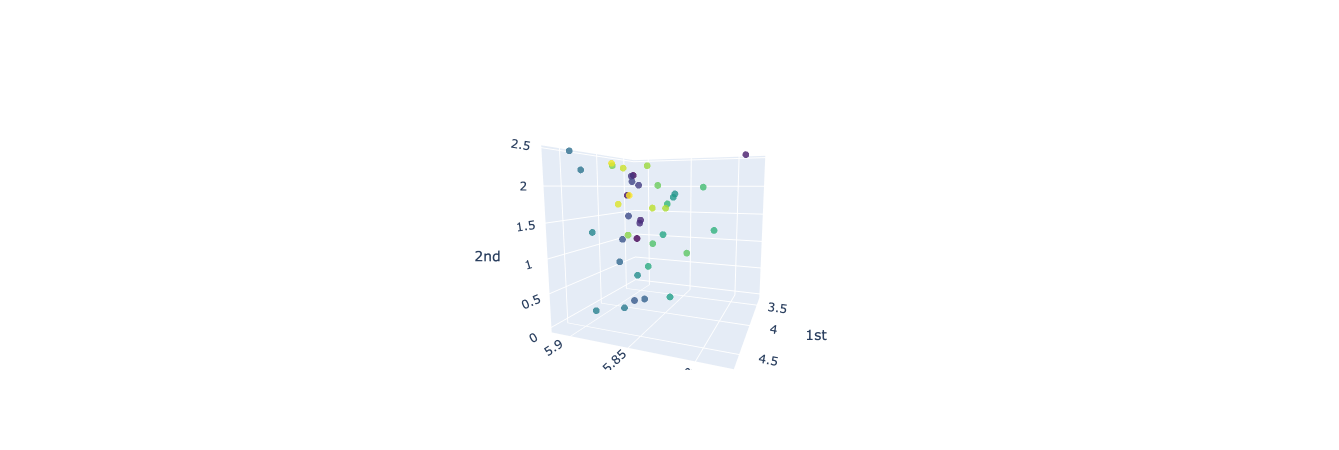

In [ ]:
plot_point_cloud(X)

Unlike our simple shapes example, we do not see distinct clusters so we expect our classifier performance to be less than perfect in this case. Before we can train a model, we need to define a target vector for each point cloud. A crude, but simple way is to label each class with an integer starting from 0 to $n_\mathrm{classes} - 1$:

In [ ]:
labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X, labels)
# score
rf.oob_score_

0.725

## Topology of images

Persistent homology can also be used to study images by treating the pixels as a point cloud in Euclidean space. However, in this case it is better to use so-called _cubical complexes_ instead of Vietoris-Rips, as the former can exploit the grid-like structure of images. As the name suggests, a cubical complex is built from _cubes_ instead of _simplices_. The following examples are adapted from C. Tralie's TDALabs [repository](https://github.com/ctralie/TDALabs).

### Gaussian blobs

As a warmup, let's create a synthetic "image" involving 3 negative Gaussians:

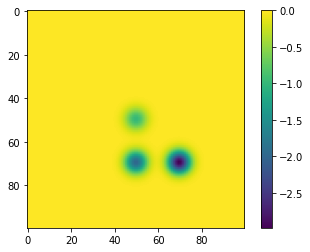

In [ ]:
ts = np.linspace(-1, 1, 100)
x1 = np.exp(-(ts ** 2) / (0.1 ** 2))
ts -= 0.4
x2 = np.exp(-(ts ** 2) / (0.1 ** 2))
# create image
img = -x1[None, :] * x1[:, None] - 2 * x1[None, :] * x2[:, None] - 3 * x2[None, :] * x2[:, None]
# plot image
plt.imshow(img)
plt.colorbar()
plt.show()

As noted [here](https://arxiv.org/pdf/1910.08345.pdf), a greyscale image comes equipped with a natural filtration on the values of its pixels. In particular, one can define a filtration of cubical complexes that are ordered by the intensity or greyscale value. So to apply cubical persistence in `giotto-tda` we need to pass a _greyscale image_ so let's simply rescale the points in our Gaussian blobs to lie in the interval $[0, 255]$ where 0 is dark and 255 is bright:

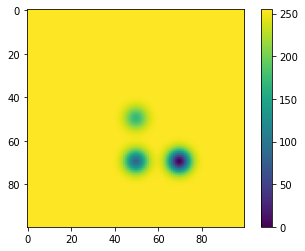

In [ ]:
img_scaled = 255 * (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(img_scaled)
plt.colorbar()
plt.show()

This "image" is now suitable for generating persistence diagrams from, and we can generate the plot in one go as follows:

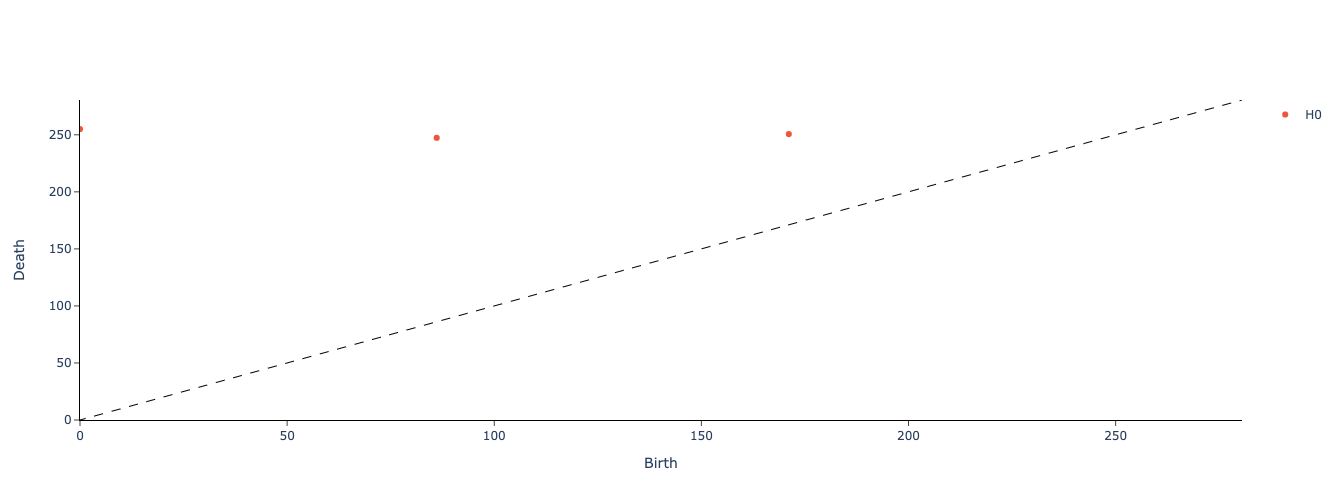

In [ ]:
# reshape input array to be (n_samples, n_pixels_x, n_pixels_y)
CubicalPersistence(homology_dimensions=[0]).fit_transform_plot(img_scaled[None, :, :]);

From this simple example, we see that are 3 dots corresponding to each of the 3 Gaussians.

Next, let's look at the famous image of a [black hole silloutte](https://www.jpl.nasa.gov/edu/news/2019/4/19/how-scientists-captured-the-first-image-of-a-black-hole/):

In [ ]:
bh_original = plt.imread(DATA/'BlackHole.jpg')
bh_grey = np.asarray(Image.fromarray(bh_original).convert("L"))

In [ ]:
def plot_images(original, greyscale):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,10))
    
    ax0.set_title(f"Image shape: {original.shape}")
    ax0.imshow(original)
    ax0.axis('off')
    
    ax1.set_title(f"Image shape: {greyscale.shape}")
    ax1.imshow(greyscale, cmap='gray')
    ax1.axis('off')
    
    plt.show()

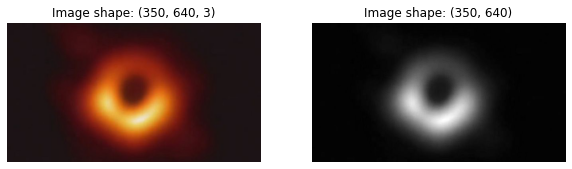

In [ ]:
plot_images(bh_original, bh_grey)

As before, we can pass our greyscale image and calculate the persistence diagram:

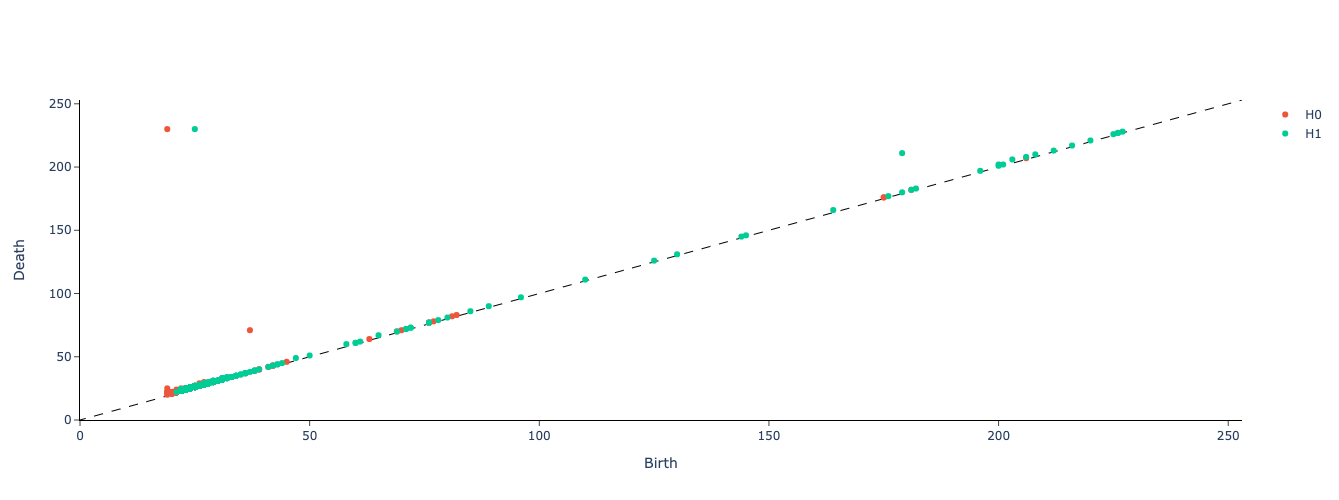

In [ ]:
CubicalPersistence(homology_dimensions=[0, 1]).fit_transform_plot(bh_grey[None, :, :]);

Nice, we've just confirmed that a black hole actually has a hole!

One interesting application of cubical persistence concerns image segmentation. Consider for example an image of wood cells, with a blurred counterpart to encourage the segmentation to focus on more robust features:

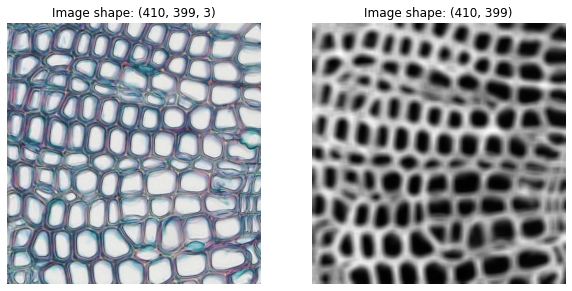

In [ ]:
cells_original = plt.imread(DATA/"Cells.jpg")
cells_grey = np.asarray(Image.fromarray(cells_original).convert("L"))
cells_blurred = -ndimage.uniform_filter(cells_grey.astype(np.float64), size=10)
cells_blurred += 0.01 * np.random.randn(*cells_blurred.shape)

plot_images(cells_original, cells_blurred)

As before we can calculate the persistence diagram as usual:

In [ ]:
dgm = CubicalPersistence(homology_dimensions=[0]).fit_transform(cells_blurred[None, :, :])

but will plot the _lifetime_ vs _birth_ for reasons that will shortly become clear:

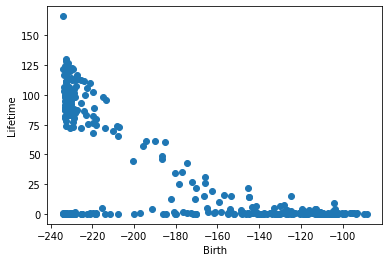

In [ ]:
plt.scatter(dgm[0][:, 0], dgm[0][:, 1] - dgm[0][:, 0])
plt.xlabel('Birth')
plt.ylabel('Lifetime')
plt.show()

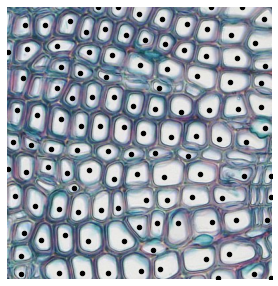

In [ ]:
thresh = 70
idxs = np.arange(dgm[0].shape[0])
idxs = idxs[np.abs(dgm[0][:, 1] - dgm[0][:, 0]) > thresh]

plt.figure(figsize=(8, 5))
plt.imshow(cells_original)

X, Y = np.meshgrid(np.arange(cells_blurred.shape[1]), np.arange(cells_blurred.shape[0]))
X = X.flatten()
Y = Y.flatten()
for idx in idxs:
    bidx = np.argmin(np.abs(-cells_blurred + dgm[0][idx, 0]))
    plt.scatter(X[bidx], Y[bidx], 20, "k")
plt.axis("off")

plt.show()

Not bad! With only two tunable parameters (blurring and threshold) we have managed to get excellent performance in a fully unsupervised manner!

## Exercises

* Experiment with the shapes dataset to see whether including the [_amplitude_](https://giotto-ai.github.io/gtda-docs/latest/modules/diagrams.html#features) of persistent diagrams improves performance compared to persistent entropy alone. You may also want to compare how the performance is affected according to each homology class, i.e. building a classifier with just the persistent entropies for $H_0$ vs $H_1$ vs $H_2$.
* Pick an image of your choosing and see if you can extract topological features from it using the techniques in this notebook.
* Advanced: try to reproduce the results from the paper where `giotto-tda` was used to classify hand-written digits: https://arxiv.org/pdf/1910.08345.pdf. Note this is not trivial, but would be a very instructive experience!